In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [3]:
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
data.columns = ["date", "time", "page", "student_id", "cohort_id", "ip"]
data.replace(regex=r'^/$', value='home_page', inplace=True)

In [4]:
cohort_21_ipapi = pd.read_csv('cohort_21_ipapi.csv', sep=",")

In [5]:
data.fillna(0, inplace = True)

In [6]:
staff = data.where(data.cohort_id == 0).dropna()

In [7]:
cohort_21 = data.where(data.cohort_id == 21).dropna()

In [8]:
cohort_21.head()

,date,time,page,student_id,cohort_id,ip
23,2018-01-26,10:08:22,mkdocs/search_index.json,10.0,21.0,97.105.19.61
24,2018-01-26,10:08:34,git/merge-conflict-demo,10.0,21.0,97.105.19.61
25,2018-01-26,10:08:45,mkdocs/search_index.json,10.0,21.0,97.105.19.61
26,2018-01-26,10:08:55,git/working-in-teams,10.0,21.0,97.105.19.61
39,2018-01-26,10:18:22,home_page,10.0,21.0,97.105.19.61


In [9]:
cohort_21_ipapi.head()

,IP Address,City,Region,Country,Postal Code,"Lat, Long",Timezone,Organization
0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc
1,12.189.101.90,San Antonio,Texas,US,78260,"29.7, -98.5",America/Chicago (-0500),"AT&T Services, Inc."
2,104.193.225.250,Longview,Texas,US,75602,"32.5, -94.7",America/Chicago (-0500),"HIVELOCITY, Inc."
3,12.247.3.42,San Antonio,Texas,US,78204,"29.4, -98.5",America/Chicago (-0500),"AT&T Services, Inc."
4,174.207.5.52,Austin,Texas,US,78704,"30.2, -97.8",America/Chicago (-0500),Cellco Partnership DBA Verizon Wireless


In [10]:
cohort_21_ipapi.rename(columns={'IP Address':'ip'}, inplace=True)

In [11]:
c21= cohort_21.merge(cohort_21_ipapi, on='ip')

In [12]:
new_latlong = c21['Lat, Long'].str.rsplit(",", n=1, expand=True)
c21["lat"]= new_latlong[0]
c21["long"]= new_latlong[1]

In [13]:
c21['datetime'] = c21[['date', 'time']].apply(lambda x: ' '.join(x), axis=1)
c21.datetime= pd.to_datetime(c21.datetime) 

In [14]:
c21 = c21.set_index('datetime')

In [15]:
c21.head()

,date,time,page,student_id,cohort_id,ip,City,Region,Country,Postal Code,"Lat, Long",Timezone,Organization,lat,long
datetime,,,,,,,,,,,,,,,
2018-01-26 10:08:22,2018-01-26,10:08:22,mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc,29.5,-98.4
2018-01-26 10:08:34,2018-01-26,10:08:34,git/merge-conflict-demo,10.0,21.0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc,29.5,-98.4
2018-01-26 10:08:45,2018-01-26,10:08:45,mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc,29.5,-98.4
2018-01-26 10:08:55,2018-01-26,10:08:55,git/working-in-teams,10.0,21.0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc,29.5,-98.4
2018-01-26 10:18:22,2018-01-26,10:18:22,home_page,10.0,21.0,97.105.19.61,San Antonio,Texas,US,78239,"29.5, -98.4",America/Chicago (-0500),Charter Communications Inc,29.5,-98.4


In [16]:
c21.columns

Index(['date', 'time', 'page', 'student_id', 'cohort_id', 'ip', 'City',
       'Region', 'Country', 'Postal Code', 'Lat, Long', 'Timezone',
       'Organization', 'lat', 'long'],
      dtype='object')

In [17]:
c21 = c21.reindex(columns=['Timezone', 'page', 'student_id', 'cohort_id', 'ip', 'City','Region'])

In [18]:
c21.head()

,Timezone,page,student_id,cohort_id,ip,City,Region
datetime,,,,,,,
2018-01-26 10:08:22,America/Chicago (-0500),mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas
2018-01-26 10:08:34,America/Chicago (-0500),git/merge-conflict-demo,10.0,21.0,97.105.19.61,San Antonio,Texas
2018-01-26 10:08:45,America/Chicago (-0500),mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas
2018-01-26 10:08:55,America/Chicago (-0500),git/working-in-teams,10.0,21.0,97.105.19.61,San Antonio,Texas
2018-01-26 10:18:22,America/Chicago (-0500),home_page,10.0,21.0,97.105.19.61,San Antonio,Texas


In [19]:
c21.shape

(6465, 7)

In [20]:
len(c21.page.unique())

284

In [21]:
le = LabelEncoder()
encoder_page = LabelEncoder()
encoder_page.fit(c21.page)
c21 = c21.assign(page_encode=encoder_page.transform(c21.page))

In [22]:
c21.head()

,Timezone,page,student_id,cohort_id,ip,City,Region,page_encode
datetime,,,,,,,,
2018-01-26 10:08:22,America/Chicago (-0500),mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas,215
2018-01-26 10:08:34,America/Chicago (-0500),git/merge-conflict-demo,10.0,21.0,97.105.19.61,San Antonio,Texas,120
2018-01-26 10:08:45,America/Chicago (-0500),mkdocs/search_index.json,10.0,21.0,97.105.19.61,San Antonio,Texas,215
2018-01-26 10:08:55,America/Chicago (-0500),git/working-in-teams,10.0,21.0,97.105.19.61,San Antonio,Texas,121
2018-01-26 10:18:22,America/Chicago (-0500),home_page,10.0,21.0,97.105.19.61,San Antonio,Texas,123


In [23]:
c21.index.min()

Timestamp('2018-01-26 10:08:22')

In [24]:
c21.index.max()

Timestamp('2019-04-01 16:08:14')

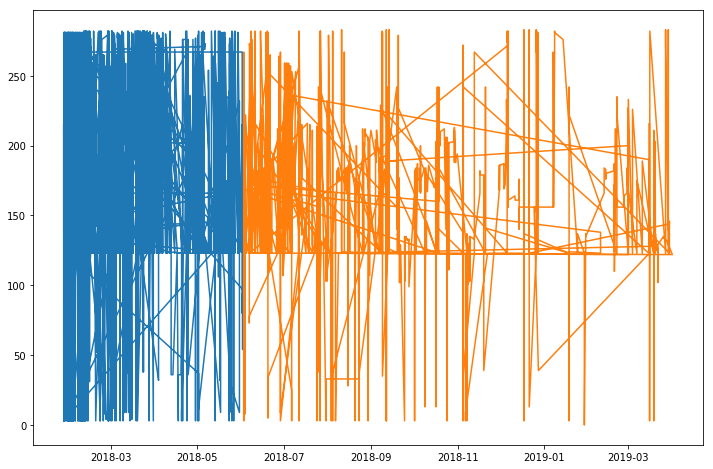

In [25]:
start_date_train = c21.page_encode.head(1).index[0]
end_date_train = '2018-06-01 23:59:59'
start_date_test = '2018-06-02 00:00:00'

train = c21.page_encode[:end_date_train]
test = c21.page_encode[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [26]:
ip_data = {}
for ip in data.ip.unique():
    api_path = f"http://api.ipapi.com/{ip}?access_key={env.api_key}"
    data = requests.get(api_path).json()
    ip_data[ip] = data

NameError: name 'env' is not defined